# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
whos

Interactive namespace is empty.


In [2]:
import numpy as np
import pandas as pd
from asl_data import AslDb
import matplotlib.pyplot as plt

# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [3]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [4]:
# asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
# asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
# asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

##### Try it!

In [5]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-rx  grnd-ry  grnd-lx  grnd-ly  
video frame                                      
98    0            9      113      -12      119  
      1            9      113      -12      119  
      2            9      113      -12      119  
      3            9      113      -12      119  
      4            9      113      -12      119

In [6]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
#show a single set of features for a given (video, frame) tuple 
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have loaded into the training set:

In [7]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))


Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

###### N.B.  
    M, L = training.get_word_Xlengths('CHOCOLATE') 
    # There are len(L) many sequences (i.e. samples) for word 'CHOCOLATE'
    M.shape == (a, b)   
    a == sum(L)
    b == sum(features_ground)
    # the time signal data regarding for sample 1 for 'CHOCOLATE' is
    M[:L[0], :]
    # that of sample 2 is
    M[L[0]:L[1], :]
    

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-rx,grnd-ry,grnd-lx,grnd-ly
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,-19.567406,88.728430,31.216447,157.036848
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,-11.637255,60.087364,2.006318,104.026144
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,-13.452679,61.813616,12.895536,118.505134


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df[4000:4010]

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
84    57        156     180      163      164     165      65  woman-1   
      58        150     184      165      170     165      65  woman-1   
      59        150     184      165      176     165      65  woman-1   
      60        150     184      165      176     165      65  woman-1   
      61        150     184      165      176     165      65  woman-1   
      62        150     184      167      175     165      65  woman-1   
      63        149     184      167      175     165      65  woman-1   
      64        149     184      167      175     165      65  woman-1   
147   0         155     183      165      169     163      60  woman-1   
      1         155     183      165      169     163      60  woman-1   

             grnd-rx  grnd-ry  grnd-lx  grnd-ly  left-x-mean  
video frame                                                   
84    57          -2       99       -9      115   164.661438  
      58           0      105      -15      119   164.661438  
      59           0      111      -15      119   164.661438  
      60           0      111      -15      119   164.661438  
      61           0      111      -15      119   164.661438  
      62           2      110      -15      119   164.661438  
      63           2      110      -16      119   164.661438  
      64           2      110      -16      119   164.661438  
147   0            2      109       -8      123   164.661438  
      1            2      109       -8      123   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)


df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-rx,grnd-ry,grnd-lx,grnd-ly,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,20.269032,53.487999,15.080360,36.572749,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,16.764706,33.972660,17.328941,27.117393,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,16.191324,39.128572,15.050938,29.320655,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

std_rx = asl.df['speaker'].map(df_std['right-x'])
std_ry = asl.df['speaker'].map(df_std['right-y'])
std_lx = asl.df['speaker'].map(df_std['left-x'])
std_ly = asl.df['speaker'].map(df_std['left-y'])

mean_rx = asl.df['speaker'].map(df_means['right-x'])
mean_ry = asl.df['speaker'].map(df_means['right-y'])
mean_lx = asl.df['speaker'].map(df_means['left-x'])
mean_ly = asl.df['speaker'].map(df_means['left-y'])

shifted_rx = asl.df['right-x'] - mean_rx
shifted_ry = asl.df['right-y'] - mean_ry
shifted_lx = asl.df['left-x'] - mean_lx
shifted_ly = asl.df['left-y'] - mean_ly

asl.df['norm-rx'] = shifted_rx / std_rx
asl.df['norm-ry'] = shifted_ry / std_ry
asl.df['norm-lx'] = shifted_lx / std_lx
asl.df['norm-ly'] = shifted_ly / std_ly

features_norm = ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

rx = asl.df['grnd-rx']
ry = asl.df['grnd-ry']
lx = asl.df['grnd-lx']
ly = asl.df['grnd-ly']

asl.df['polar-rr'] = np.sqrt(rx**2 + ry**2)
asl.df['polar-rtheta'] = np.arctan2(rx,ry)
asl.df['polar-lr'] = np.sqrt(lx**2 + ly**2)
asl.df['polar-ltheta'] = np.arctan2(lx,ly)

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']


In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-rx'] = asl.df.groupby(asl.df.index.get_level_values(0))['grnd-rx'].diff()
asl.df['delta-ry'] = asl.df.groupby(asl.df.index.get_level_values(0))['grnd-ry'].diff()
asl.df['delta-lx'] = asl.df.groupby(asl.df.index.get_level_values(0))['grnd-lx'].diff()
asl.df['delta-ly'] = asl.df.groupby(asl.df.index.get_level_values(0))['grnd-ly'].diff()

asl.df.fillna(method='backfill', inplace=True)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
# Gonna try a features_delta based on normalized positions, instead of ground positions

# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['norm-delta-rx'] = asl.df.groupby(asl.df.index.get_level_values(0))['norm-rx'].diff()
asl.df['norm-delta-ry'] = asl.df.groupby(asl.df.index.get_level_values(0))['norm-ry'].diff()
asl.df['norm-delta-lx'] = asl.df.groupby(asl.df.index.get_level_values(0))['norm-lx'].diff()
asl.df['norm-delta-ly'] = asl.df.groupby(asl.df.index.get_level_values(0))['norm-ly'].diff()

asl.df.fillna(method='backfill', inplace=True)

features_custom2 = ['norm-delta-rx', 'norm-delta-ry', 'norm-delta-lx', 'norm-delta-ly']

In [15]:
df_std = asl.df.groupby('speaker').std()
df_means = asl.df.groupby('speaker').mean()

std_polar_rr = asl.df['speaker'].map(df_std['polar-rr'])
std_polar_lr = asl.df['speaker'].map(df_std['polar-lr'])

std_rr = asl.df['speaker'].map(df_std['polar-rr'])
std_lr = asl.df['speaker'].map(df_std['polar-lr'])
std_rtheta = asl.df['speaker'].map(df_std['polar-rtheta'])
std_ltheta = asl.df['speaker'].map(df_std['polar-ltheta'])

mean_rr = asl.df['speaker'].map(df_means['polar-rr'])
mean_lr = asl.df['speaker'].map(df_means['polar-lr'])
mean_rtheta = asl.df['speaker'].map(df_means['polar-rtheta'])
mean_ltheta = asl.df['speaker'].map(df_means['polar-ltheta'])

asl.df['norm-polar-rr'] = np.sqrt(rx**2 + ry**2) / std_polar_rr
asl.df['norm-polar-lr'] = np.sqrt(lx**2 + ly**2) / std_polar_lr
asl.df['norm-polar-rtheta'] = np.arctan2(rx,ry)
asl.df['norm-polar-ltheta'] = np.arctan2(lx,ly)

features_custom = ['norm-polar-rr', 'norm-polar-lr', 'norm-polar-ltheta', 'norm-polar-rtheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 
>  Two additional sets of features have been used.   
  
> *  **features_custom** is based on normalized polar coordinates. Normalizing the polar coordinate features is an attempt to alleviate any spurious dissimilarities that could arise from the differences in speakers' bodies, size of their torsos, shoulders and arm lengths.
> *  **features_custom2** is the velocities (`delta`'s) computed from normalized coordinates (unlike **features_delta** computed on `'grnd-rx'` etc). This is an attempt to alleviate a similar problem that could arise fomr the size and shape of the upper bodies of the speakers.



<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample sequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [19]:
my_testword = 'BILL'
model, logL = train_a_word(my_testword, 4, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for BILL is 4
hidden state #0
mean =  [ -18.41666667   60.5          31.83333333  173.75      ]
variance =  [  4.41055556  10.75083333   2.13972222   5.18833333]

hidden state #1
mean =  [  14.21875   25.75      -7.8125   127.8125 ]
variance =  [ 24.10871094   6.1253125    1.71515625   1.96515625]

hidden state #2
mean =  [   7.33333333   46.88888889   38.22222222  181.11111111]
variance =  [ 46.89        11.21098765   2.39617284   1.43320988]

hidden state #3
mean =  [   7.88888889   23.44444444    9.          121.        ]
variance =  [  4.54432099e+00   2.89146914e+01   1.11111111e-03   1.11111111e-03]

logL = -481.7640610999387


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [20]:
%matplotlib inline

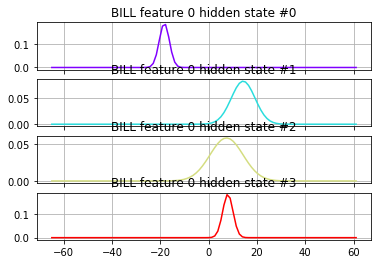

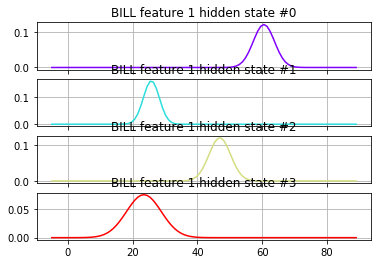

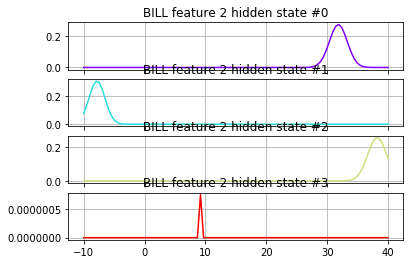

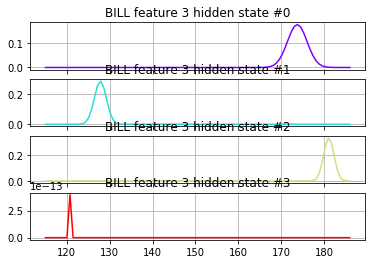

In [21]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `ModelSelector` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [22]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), \
                         word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely overfit as complexity is added.  To estimate which model topology is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold is scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [23]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model likelihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [24]:
sequences = training.get_all_sequences()
for k, v in sorted(sequences.items(), key=lambda x: x[0]):
    print("{} -- {} sequences".format(k, len(v)))
    

ALL -- 2 sequences
ANN -- 1 sequences
APPLE -- 5 sequences
ARRIVE -- 15 sequences
BILL -- 6 sequences
BLAME -- 4 sequences
BLUE -- 4 sequences
BOOK -- 18 sequences
BORROW -- 1 sequences
BOX -- 5 sequences
BOY -- 4 sequences
BREAK-DOWN -- 4 sequences
BROCCOLI -- 2 sequences
BROTHER -- 2 sequences
BUT -- 2 sequences
BUY -- 16 sequences
BUY1 -- 6 sequences
CAN -- 17 sequences
CANDY -- 1 sequences
CAR -- 16 sequences
CHICAGO -- 1 sequences
CHICKEN -- 2 sequences
CHINA -- 2 sequences
CHOCOLATE -- 3 sequences
COAT -- 2 sequences
CORN -- 3 sequences
CORN1 -- 2 sequences
DECIDE -- 2 sequences
EAT -- 5 sequences
FIND -- 1 sequences
FINISH -- 5 sequences
FISH -- 2 sequences
FRANK -- 4 sequences
FRED -- 1 sequences
FRIEND -- 1 sequences
FUTURE -- 15 sequences
FUTURE1 -- 2 sequences
GET -- 1 sequences
GIRL -- 5 sequences
GIVE -- 9 sequences
GIVE1 -- 6 sequences
GIVE2 -- 1 sequences
GIVE3 -- 2 sequences
GO -- 12 sequences
GO1 -- 4 sequences
GO2 -- 1 sequences
GROUP -- 1 sequences
HAVE -- 5 sequence

In [25]:
words_to_train = ['FISH', 'ANN', 'BROCCOLI', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [28]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer() - start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.7160370859783143 seconds
Training complete for ANN with 2 states with time 0.3559920429252088 seconds
Training complete for BROCCOLI with 2 states with time 0.6307891739998013 seconds
Training complete for BOOK with 6 states with time 5.378021755022928 seconds
Training complete for VEGETABLE with 2 states with time 2.0517176119610667 seconds
Training complete for FUTURE with 2 states with time 4.996374446898699 seconds
Training complete for JOHN with 12 states with time 54.29573328094557 seconds


In [29]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.10480095306411386 seconds
Training complete for ANN with 2 states with time 0.03828621795400977 seconds
Training complete for BROCCOLI with 7 states with time 0.18467846186831594 seconds
Training complete for BOOK with 8 states with time 2.5503796481061727 seconds
Training complete for VEGETABLE with 9 states with time 0.9602397608105093 seconds
Training complete for FUTURE with 9 states with time 2.8146257118787616 seconds
Training complete for JOHN with 13 states with time 25.587724428158253 seconds


In [30]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.1714620480779558 seconds
Training complete for ANN with 2 states with time 0.48899447405710816 seconds
Training complete for BROCCOLI with 7 states with time 1.6780257117934525 seconds
Training complete for BOOK with 15 states with time 5.173956802114844 seconds
Training complete for VEGETABLE with 15 states with time 4.101630709134042 seconds
Training complete for FUTURE with 15 states with time 5.456049495842308 seconds
Training complete for JOHN with 15 states with time 28.036790286190808 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**   

>In order to asses the performance of a certain HMM model topology against other topologies 3 different techniqueshave been used --**k-folding**, **BIC** and **DIC**. In the context of this project, *topology* of the model refers to the number of hidden states it harbors.

>The Occam’s Razor principle is one of parsimony, that is a model should be both simple enough for efficient computation and complex enough to be able to capture data specifics [Biem 2003]. The purpose of assessing different topologies of the model is to be able to select one that has high performance and yet is computationally efficient and has a small number of states.

>When training different models, it is possible to improve the performance of the model by adding more free parameters makes it fit the particular specifics of the data samples contained in the training set (overfitting), rather than explaining the general patterns of it. 

>In `SelectorCV`, **k-folding** cross-validation technique is employed. Here, an HMM model with a certain topology and a given word, k-folding splits the data into k-many segments and aggregates **(k-1)-many** of them to assign to be the training data, and the one remaining segment is assigned to test data. Subsequently, **k-many** test and training set combinations are formed yielding **k** different log-likelihood values. The average of these designates the performance score of the given  **HMM** topology (larger implies a more favorable score). **k-folding** is a simple abnd straightforward technique that can be easily generalized to any machine learning model. For this technique to work well, one needs plenty amount of data so some of this will exclusively be used for model assesment. 

>**BIC** (Bayesian Information Criterion), which maximizes the likelihood of the data while penalizing models with high complexity [Biem 2003]. The **BIC** criterion favours simple models adds a penalty for model complexity described by the free parameters of the model. **BIC** worked faster than both **DIC** and **k-folding** and it also favored simpler models than **DIC** did.

>**DIC** (Discriminative Information Criterion) produces a score based on the difference of the "log-likelihood of the evidence" and the "average log-likelihiood of the anti-evidence" (anti-log-likelihood). Hence, **DIC** scores the model not only by assessing how likely it is to produce the given word but also on how unlikely it is to confuse it with another word in the vocabulary. **BIC** and **DIC**, contrary to **k-folding**, don't need to devote a portion of the data hence leaves more of it for training.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [31]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 66.290s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [32]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [33]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [35]:
# TODO Choose a feature set and model selector
start = timeit.default_timer()
features = features_delta # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print("model_selector:{} \nrun time = {} seconds".format(model_selector.__name__,end))
show_errors(guesses, test_set)


model_selector:SelectorConstant 
run time = 26.209774018032476 seconds

**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *HAVE *GIVE1 *TEACHER                                    JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN *MARY WONT *MARY *CAR *GO *SHOULD *MARY                  JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN *JOHN *MARY                                    JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *MARY *NOT IX IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *JOHN *NOT *GIVE3 *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *WHO *SEE *APPLE                          

In [36]:
# TODO Choose a feature set and model selector
start = timeit.default_timer()
features = features_delta # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print("model_selector:{} \nrun time = {} seconds".format(model_selector.__name__,end))
show_errors(guesses, test_set)

model_selector:SelectorBIC 
run time = 109.0240824969951 seconds

**** WER = 0.6123595505617978
Total correct: 69 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *STUDENT GO *TEACHER                                     JOHN CAN GO CAN
   12: JOHN *BOX *FUTURE CAN                                         JOHN CAN GO CAN
   21: *MARY *MARY WONT *MARY *CAR *BROTHER *VISIT *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *WOMAN *JOHN *JOHN IX                                    JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *WHO *SOMETHING-ONE *POSS IX                             JOHN LIKE IX IX IX
   36: *JOHN *JOHN *IX *GO *BOY *MARY                                MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *JOHN *WRITE                               

In [37]:
# TODO Choose a feature set and model selector
start = timeit.default_timer()
features = features_delta # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print("model_selector:{} \nrun time = {} seconds".format(model_selector.__name__,end))
show_errors(guesses, test_set)


model_selector:SelectorDIC 
run time = 257.6765338177793 seconds

**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX *ARRIVE                                              JOHN WRITE HOMEWORK
    7: JOHN *BOX *GIVE1 *ARRIVE                                      JOHN CAN GO CAN
   12: JOHN *BOX *FUTURE CAN                                         JOHN CAN GO CAN
   21: *MARY *MARY *JOHN *MARY *WHAT *IX *MARY *MARY                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *WOMAN *JOHN *JOHN IX                                    JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *WOMAN                                    JOHN LIKE IX IX IX
   30: JOHN *JOHN *SOMETHING-ONE IX IX                               JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN *NEW-YORK *JOHN *JOHN                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN *JOHN *MARY                                

In [38]:
# TODO Choose a feature set and model selector
start = timeit.default_timer()
features = features_delta # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
end = timeit.default_timer() - start
print("model_selector:{} \nrun time = {} seconds".format(model_selector.__name__,end))
show_errors(guesses, test_set)


model_selector:SelectorCV 
run time = 213.52725494699553 seconds

**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: JOHN *FUTURE *GO1                                             JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *GIVE1 *TEACHER                                  JOHN CAN GO CAN
   12: JOHN *BOX *GO1 CAN                                            JOHN CAN GO CAN
   21: JOHN *JOHN WONT *MARY *CAR *GO *MARY *MARY                    JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *WOMAN *JOHN *JOHN *MARY                                 JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY IX *WOMAN                                    JOHN LIKE IX IX IX
   30: JOHN *JOHN *SHOULD IX *SHOULD                                 JOHN LIKE IX IX IX
   36: MARY *MARY *JOHN *LIKE *BOY *JOHN                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *JOHN MARY *MARY                                 

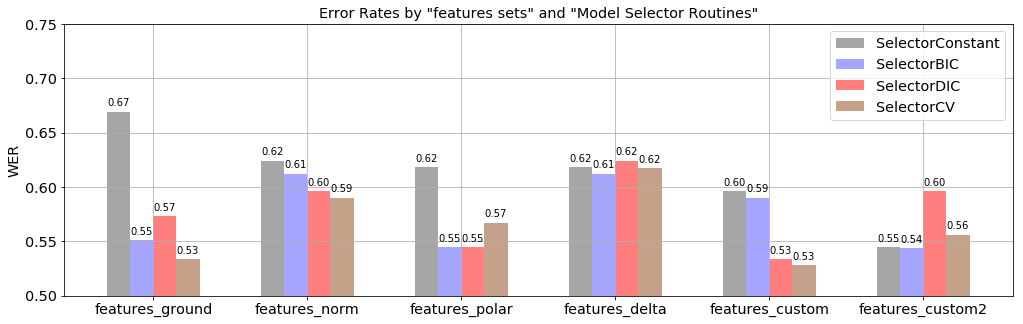

In [66]:
'''
                   features_ground  features_norm   features_polar  features_delta   features_custom    features_custom2
SelectorConstant   0.669            0.624           0.618           0.618            0.596              0.545               
SelectorBIC        0.551            0.612           0.545           0.612            0.590              0.544      
SelectorDIC        0.573            0.596           0.545           0.624            0.534              0.596 
SelectorCV         0.534            0.590           0.567           0.617            0.528              0.556
'''

WER = np.array([
                [0.669, 0.624, 0.618, 0.618, 0.596, 0.545],
                [0.551, 0.612, 0.545, 0.612, 0.590, 0.544],
                [0.573, 0.596, 0.545, 0.624, 0.534, 0.596],
                [0.534, 0.590, 0.567, 0.617, 0.528, 0.556]
])

# Set the fontsize of the figure globally
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (17, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

fig = plt.figure()
ax = plt.subplot(111)
width = 0.15
plt.grid('on')
ax.set_ylim((.5,.75))
xpos = np.arange(6)
#
rects0 = ax.bar(xpos+0.5*width, WER[0,:], width=width, color='k', alpha=.35)
rects1 = ax.bar(xpos+1.5*width, WER[1,:], width=width, color='b', alpha=.35)
rects2 = ax.bar(xpos+2.5*width, WER[2,:], width=width, color='r', alpha=.5)
rects3 = ax.bar(xpos+3.5*width, WER[3,:], width=width, color='#8B4513', alpha=.5)
rects_list = [rects0, rects1, rects2, rects3]
ax.legend(('SelectorConstant', 'SelectorBIC', 'SelectorDIC', 'SelectorCV'))

def autolabel(rects_list):
    for rects in rects_list:
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.006*height,
                '%3.2f' % height,
                ha='center', va='bottom')

autolabel(rects_list)

ax.set_ylabel('WER')
ax.set_title('Error Rates by "features sets" and "Model Selector Routines"')
ax.set_xticks(xpos + 2*width)
ax.set_xticklabels(('features_ground', 'features_norm', 'features_polar', 'features_delta', 'features_custom', 'features_custom2'))
print (" ")
plt.show()

Figure 1.

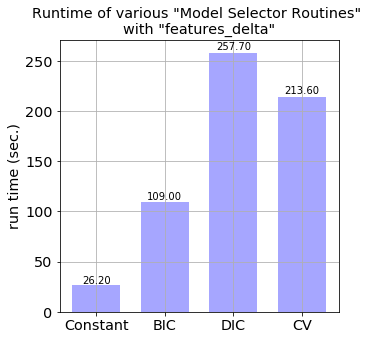

In [92]:
# RUNTIME COMPARISON. (fixed: features_delta)
'''
SelectorConstant:   26.2097 sec
SelectorBIC:        109.024 sec
SelectorDIC:        257.676 sec
SelectorCV:         213.527 sec
'''
runtimes = [26.2, 109.0, 257.7, 213.6]

fig = plt.figure()
ax = plt.subplot(132)

width = 0.7
plt.grid('on')
# ax.set_ylim((.5,.75))
xpos = np.arange(4)
#
rects0 = ax.bar(xpos+0.5*width, runtimes, width=width, color='b', alpha=.35)

# def autolabel(rects_list):
#     for rects in rects_list:
#         for rect in rects:
#             height = rect.get_height()
#             ax.text(rect.get_x() + rect.get_width()/2., 1.006*height,
#                 '%3.2f' % height,
#                 ha='center', va='bottom')

autolabel([rects0])

ax.set_ylabel('run time (sec.)')
ax.set_title('Runtime of various "Model Selector Routines" \nwith "features_delta"')
ax.set_xticks(xpos+0.5*width)
ax.set_xticklabels(('Constant', 'BIC', 'DIC', 'CV'), rotation=0)

plt.show()


Figure 2.

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**  
#### EVALUATION OF WORD ERROR RATE (WER): 
> Aside from the four sets of features provided --that is `features_ground`, `features_norm`, `features_polar` and 
 `features_delta`-- two additional sets of features have been used: 
  
> *  `features_custom` is based on normalized polar coordinates, and  
> *  `features_custom2` is the velocities (`delta`'s) computed from normalized coordinates (unlike `features_delta` computed on `'grnd-rx'` etc)
  
> Excluding the SelectorConstant class, overall the **WER** scores ranged from 0.53 to 0.62 for all combinations of feature and Model Selector routines.


> It's observed that the `features_custom` yielded the best performance metric, WER across the board. Another interesting observation is that `features_ground` produced better performance than the normalized counterpart `features_norm`.

#### EVALUATION OF RUNTIME: 
>The `features_delta` set has been fixed different model selector routines to compare their relative runtimes. The results are presneted in Figure 2. `SelectorDIC` being the slowest amongst the three of them, `SelectorCV` is a close second and approximately, `SelectorBIC` runs more than two times faster than `SelectorDIC` and `SelectorCV`. 




<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [262]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 37.323s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()